## Includes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import glob

# Latex results

In [2]:
results = [pd.read_csv(path) for path in glob.glob("../logs/*csv")]
results = pd.concat(results)
# Clean dataframe
results = results.apply(lambda x: x.apply(lambda y: y.split(' ')[1][:-1]))
results

,eeg_feature,model,hidden_channels,window_size,batch_size,learning_rate,dropout_rate,weight_decay,activation_funct,number_train_samples,...,val_f1,val_prec,val_reca,val_roc,pytorch_total_params,train_time,best_epoch,experiment_id,train_samples,val_samples
0,'wav','CNN',256,0.25,32,0.0005,0.25,0.0,'relu',2,...,0.8522854690426398,0.872042692918295,0.8603125,0.9867886088709676,16677,3358.1363031864166,1109,'28','349,'342
1,'wav','CNN',256,0.25,32,0.0005,0.25,0.0,'relu',2,...,0.8322322273253404,0.8401366979143605,0.84375,0.983835181451613,16677,1589.5292069911957,437,'1168','151,'271
2,'wav','CNN',256,0.25,32,0.0005,0.25,0.0,'relu',2,...,0.7709894893373543,0.7875152875678328,0.776875,0.982107258064516,16677,2573.179792165756,776,'2308','855,'858
3,'wav','CNN',256,0.25,32,0.0005,0.25,0.0,'relu',2,...,0.8682450705841627,0.8704146612839095,0.8771875,0.9934779233870967,16677,1182.5789799690247,363,'3448','416,'762
4,'wav','CNN',256,0.25,32,0.0005,0.25,0.0,'relu',2,...,0.8561750756522502,0.8602070431385651,0.8678125000000001,0.98903125,16677,3261.1691002845764,1057,'4588','88,'469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,'raw','CNN',128,0.5,32,0.0005,0.25,0.0,'relu',2,...,0.3212539281471989,0.5020151059858243,0.27562499999999995,0.6472011088709678,8417,741.5718581676483,251,'863','70,'233
1,'raw','CNN',128,0.5,32,0.0005,0.25,0.0,'relu',2,...,0.21485337158288806,0.3138266526108945,0.2,0.5938967741935484,8417,814.6401047706604,202,'2003','92,'429
2,'raw','CNN',128,0.5,32,0.0005,0.25,0.0,'relu',2,...,0.25731851209488066,0.3804625240903746,0.239375,0.6173498991935484,8417,1480.1086218357086,346,'3143','417,'335
3,'raw','CNN',128,0.5,32,0.0005,0.25,0.0,'relu',2,...,0.27845263803899956,0.4001594111591623,0.2603125,0.6242639112903225,8417,1243.7532753944397,398,'4283','107,'50


In [3]:
model_names = ['LR','MLP','CNN','GraphConv']
hidden_channels = [64, 128, 256, 512, 1024, 2048]
models = list(filter(None, [f'{name}_{hc}' if not name == 'LR' else None if hc != 64 else 'LR' for name in model_names for hc in hidden_channels ]))
features = ['wav','psd','raw']
window_sizes = [0.25, 0.5, 1, 1.5, 2]
number_train_samples = [1, 2, 4, 8]

In [4]:
sorted_by_time_nts_ws = np.array([ws*nts for ws in window_sizes for nts in number_train_samples])
b = np.array([ws for ws in window_sizes for nts in number_train_samples])
c = np.array([nts for ws in window_sizes for nts in number_train_samples])
idx = np.argsort(sorted_by_time_nts_ws)
sorted_by_time_nts_ws.sort()
sorted_ws = b[idx]
sorted_nts = c[idx]

In [5]:
dfs = []

for ef in features:
    print(ef)
    df = pd.DataFrame(index=models)
    for (ws,nts) in zip(sorted_ws, sorted_nts):
        res_col = []
        for model in models:
            if model == 'LR':
                hc = 0
            else:
                model, hc = model.split('_')
                hc = int(hc)
            res = results[(results['model'] == f'\'{model}\'') & (results['hidden_channels'].astype(int)==hc) & (results['window_size'].astype(float) == ws) & (results['number_train_samples'].astype(int)==nts) & (results['eeg_feature'] == f'\'{ef}\'')]
            mean_acc = res['test_acc'].astype(float).mean()
            std_acc = res['test_acc'].astype(float).std()

            res_col.append(f'{mean_acc:.2f}±{std_acc:.2f}')
        df[f'{ef} {ws}s x{nts}'] = res_col  
    dfs.append(df)

wav
psd
raw


In [6]:
wav_df, psd_df, raw_df = dfs[0], dfs[1], dfs[2]

# Inflection points

In [7]:
lr_res = wav_df.iloc[0]
lr_res

wav 0.25s x1    0.78±0.04
wav 0.25s x2    0.87±0.02
wav 0.5s x1     0.84±0.03
wav 0.25s x4    0.93±0.01
wav 0.5s x2     0.93±0.01
wav 1.0s x1     0.91±0.01
wav 1.5s x1     0.93±0.03
wav 2.0s x1     0.95±0.01
wav 1.0s x2     0.96±0.01
wav 0.5s x4     0.97±0.01
wav 0.25s x8    0.96±0.00
wav 1.5s x2     0.98±0.01
wav 1.0s x4     0.99±0.01
wav 2.0s x2     0.99±0.00
wav 0.5s x8     0.98±0.00
wav 1.5s x4     0.99±0.00
wav 2.0s x4     1.00±0.00
wav 1.0s x8     0.99±0.00
wav 1.5s x8     1.00±0.00
wav 2.0s x8     1.00±0.00
Name: LR, dtype: object

## Option 1) Show all values

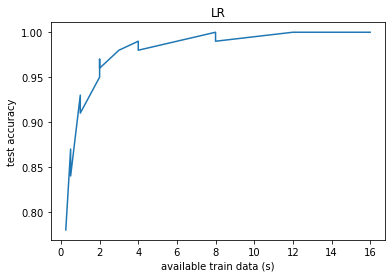

In [8]:
lr_means = np.array([float(x.split('±')[0]) for x in lr_res.to_numpy()])
lr_stds = np.array([float(x.split('±')[1]) for x in lr_res.to_numpy()])
plt.plot(sorted_by_time_nts_ws,lr_means)
plt.title('LR')
plt.xlabel('available train data (s)')
plt.ylabel('test accuracy')
plt.show()

## Option 2) Merge values for x
https://www.researchgate.net/post/How_do_I_combine_mean_and_standard_deviation_of_two_groups

In [9]:
u_sorted_by_time_nts_ws = np.unique(sorted_by_time_nts_ws)
u_sorted_by_time_nts_ws

array([ 0.25,  0.5 ,  1.  ,  1.5 ,  2.  ,  3.  ,  4.  ,  6.  ,  8.  ,
       12.  , 16.  ])

In [10]:
merged_lr_res = []
for t in u_sorted_by_time_nts_ws:
    lr_res_time = lr_res[sorted_by_time_nts_ws==t]
    means = np.array([float(x.split('±')[0]) for x in lr_res_time.to_numpy()])
    stds = np.array([float(x.split('±')[1]) for x in lr_res_time.to_numpy()])
    merged_lr_res.append(f'{means.mean():.2f}±{stds.mean():.2f}')
merged_lr_res = pd.Series(data=merged_lr_res, index=u_sorted_by_time_nts_ws)
merged_lr_res

0.25     0.78±0.04
0.50     0.85±0.03
1.00     0.92±0.01
1.50     0.93±0.03
2.00     0.96±0.01
3.00     0.98±0.01
4.00     0.99±0.00
6.00     0.99±0.00
8.00     0.99±0.00
12.00    1.00±0.00
16.00    1.00±0.00
dtype: object

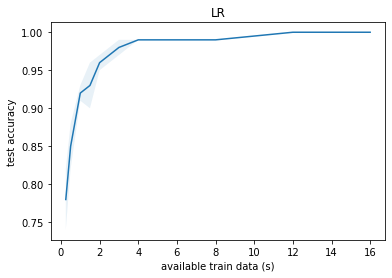

In [11]:
lr_means = np.array([float(x.split('±')[0]) for x in merged_lr_res.to_numpy()])
lr_stds = np.array([float(x.split('±')[1]) for x in merged_lr_res.to_numpy()])
plt.plot(u_sorted_by_time_nts_ws,lr_means)
plt.fill_between(u_sorted_by_time_nts_ws,lr_means-lr_stds,lr_means+lr_stds,alpha=.1)
plt.title('LR')
plt.xlabel('available train data (s)')
plt.ylabel('test accuracy')
plt.show()

# Create merged dfs

In [12]:
merged_dfs = []
for i,df in enumerate(dfs):
    merged_df_rows = []
    for row_id in range(len(df)):
        row_res = df.iloc[row_id]
        merged_row_res = []
        for t in u_sorted_by_time_nts_ws:
            raw_res_time = row_res[sorted_by_time_nts_ws==t]
            means = np.array([float(x.split('±')[0]) for x in raw_res_time.to_numpy()])
            stds = np.array([float(x.split('±')[1]) for x in raw_res_time.to_numpy()])
            merged_row_res.append(f'{means.mean():.2f}±{stds.mean():.2f}')
        # merged_row_res = pd.Series(data=merged_row_res, index=u_sorted_by_time_nts_ws)
        merged_df_rows.append(merged_row_res)
    merged_dfs.append(pd.DataFrame(merged_df_rows,index=models,columns=[f'{features[i]} {t} s.' for t in u_sorted_by_time_nts_ws]))

In [13]:
merged_wav_df, merged_psd_df, merged_raw_df = merged_dfs[0], merged_dfs[1], merged_dfs[2]

In [14]:
merged_wav_df

,wav 0.25 s.,wav 0.5 s.,wav 1.0 s.,wav 1.5 s.,wav 2.0 s.,wav 3.0 s.,wav 4.0 s.,wav 6.0 s.,wav 8.0 s.,wav 12.0 s.,wav 16.0 s.
LR,0.78±0.04,0.85±0.03,0.92±0.01,0.93±0.03,0.96±0.01,0.98±0.01,0.99±0.00,0.99±0.00,0.99±0.00,1.00±0.00,1.00±0.00
MLP_64,0.80±0.04,0.86±0.02,0.93±0.01,0.94±0.02,0.96±0.01,0.98±0.01,0.99±0.01,0.99±0.00,0.99±0.00,1.00±0.00,1.00±0.00
MLP_128,0.81±0.02,0.88±0.01,0.93±0.01,0.94±0.03,0.97±0.01,0.99±0.00,0.99±0.00,0.99±0.00,0.99±0.00,1.00±0.00,1.00±0.00
MLP_256,0.81±0.03,0.88±0.03,0.94±0.01,0.94±0.03,0.97±0.01,0.99±0.00,0.99±0.00,0.99±0.00,0.99±0.00,1.00±0.00,1.00±0.00
MLP_512,0.82±0.03,0.88±0.02,0.94±0.01,0.94±0.02,0.97±0.01,0.99±0.00,0.99±0.01,0.99±0.00,0.99±0.00,1.00±0.00,1.00±0.00
MLP_1024,0.82±0.03,0.88±0.01,0.94±0.01,0.94±0.03,0.97±0.01,0.99±0.00,0.99±0.00,0.99±0.00,1.00±0.00,1.00±0.00,1.00±0.00
MLP_2048,0.81±0.03,0.88±0.02,0.94±0.01,0.94±0.02,0.97±0.01,0.99±0.00,0.99±0.00,1.00±0.00,1.00±0.00,1.00±0.00,1.00±0.00
CNN_64,0.74±0.07,0.79±0.07,0.87±0.06,0.63±0.46,0.93±0.02,0.95±0.02,0.98±0.02,0.97±0.03,0.98±0.02,0.99±0.00,0.99±0.00
CNN_128,0.71±0.16,0.78±0.16,0.83±0.13,0.87±0.04,0.91±0.11,0.96±0.02,0.95±0.05,0.99±0.00,0.98±0.01,0.99±0.01,0.99±0.01
CNN_256,0.54±0.29,0.76±0.10,0.67±0.24,0.66±0.36,0.91±0.07,0.94±0.03,0.95±0.05,0.99±0.00,0.98±0.01,0.99±0.01,0.99±0.00


# Create latex tables for merged results

In [15]:
for i,f in enumerate(features):
    text_file = open(f'tables/{f}_table_res_merged.tex', "w")
    n = text_file.write(merged_dfs[i].to_latex(bold_rows=True))
    text_file.close()

# Plot both options side by side

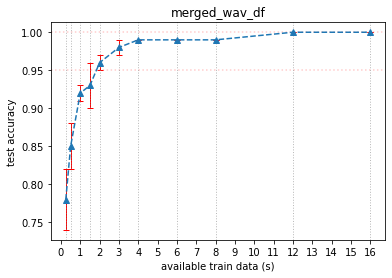

In [16]:
def show_inflection_point_graph(model_name, df, title):
    model_idx = np.where(df.index.to_numpy()==model_name)[0][0]
    res = df.iloc[model_idx]
    means = np.array([float(x.split('±')[0]) for x in res.to_numpy()])
    stds = np.array([float(x.split('±')[1]) for x in res.to_numpy()])
    x_axis = u_sorted_by_time_nts_ws if df.shape[1] == 11 else sorted_by_time_nts_ws
    n_secs = int(x_axis.max()+1)
    plt.errorbar(x_axis, means, stds, linestyle='--', marker='^',ecolor='red',elinewidth=1,capsize=3)
    plt.axhline(1, color='red',alpha=0.2,linestyle=':')
    plt.axhline(.95, color='red',alpha=0.2,linestyle=':')
    plt.xticks(list(range(n_secs)))
    for i in np.arange(0,n_secs,0.25):
#         if int(i) == i:
#             plt.axvline(i, color='gray',alpha=0.25,linestyle=':')
        if i in x_axis:
            plt.axvline(i, color='gray',alpha=0.55,linestyle=':',linewidth=1)
    
    plt.title(f'{title}')
    plt.xlabel('available train data (s)')
    plt.ylabel('test accuracy')

show_inflection_point_graph(models[0], merged_wav_df, 'merged_wav_df')

In [17]:
%%capture
from matplotlib.pyplot import figure
for i, (df,merged_df) in enumerate(zip(dfs,merged_dfs)):
    for model in models:
        figure(figsize=(20, 6), dpi=80)
        plt.subplot(1, 2, 1)
        show_inflection_point_graph(model, df, f'{model}({features[i]})')
        plt.subplot(1, 2, 2)
        show_inflection_point_graph(model, merged_df, f'{model} ({features[i]}) merged')
        plt.savefig(f'figures/{features[i]}_{model}.png')